In [91]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np
import string
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
torch.manual_seed(1)

In [12]:
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells."""

In [93]:
puncts = set(string.punctuation)
stop_words = set(stopwords.words('english'))
words = [w for w in nltk.word_tokenize(raw_text.lower()) if w not in puncts and w not in stop_words]
print(words)
print(f'Total tokens in the raw text: {len(words)}')

['study', 'idea', 'computational', 'process', 'computational', 'processes', 'abstract', 'beings', 'inhabit', 'computers', 'evolve', 'processes', 'manipulate', 'abstract', 'things', 'called', 'data', 'evolution', 'process', 'directed', 'pattern', 'rules', 'called', 'program', 'people', 'create', 'programs', 'direct', 'processes', 'effect', 'conjure', 'spirits', 'computer', 'spells']
Total tokens in the raw text: 34


In [94]:
vocab = set(words)
vocab_size = len(vocab)
vocab

{'abstract',
 'beings',
 'called',
 'computational',
 'computer',
 'computers',
 'conjure',
 'create',
 'data',
 'direct',
 'directed',
 'effect',
 'evolution',
 'evolve',
 'idea',
 'inhabit',
 'manipulate',
 'pattern',
 'people',
 'process',
 'processes',
 'program',
 'programs',
 'rules',
 'spells',
 'spirits',
 'study',
 'things'}

In [95]:
word_to_ix = {word:i for i, word in enumerate(vocab)}
word_to_ix

{'spells': 0,
 'evolution': 1,
 'rules': 2,
 'study': 3,
 'evolve': 4,
 'data': 5,
 'conjure': 6,
 'inhabit': 7,
 'beings': 8,
 'spirits': 9,
 'effect': 10,
 'create': 11,
 'idea': 12,
 'computational': 13,
 'processes': 14,
 'directed': 15,
 'process': 16,
 'computer': 17,
 'direct': 18,
 'people': 19,
 'pattern': 20,
 'programs': 21,
 'abstract': 22,
 'program': 23,
 'computers': 24,
 'things': 25,
 'manipulate': 26,
 'called': 27}

In [96]:
# Create dataset, the sample will be
# ([w_i-(n-1),... w_i-1, w_i+1,...,w_i+(n-1)], w_i)
# CONTEXT_SIZE = 2
# data = []
# for i in range(CONTEXT_SIZE, len(words) - CONTEXT_SIZE):
#     context = (
#         [words[i - j - 1] for j in range(CONTEXT_SIZE)]
#         + [words[i + j + 1] for j in range(CONTEXT_SIZE)]
#     )
#     target = words[i]
#     data.append((context, target))
# print(data[-5:])

In [97]:
n = 2 # number of words previous and after the target word
samples = [(words[i-n:i] + words[i+1:i+n+1], words[i]) for i in range(n, len(words)-n)]

In [98]:
samples[-5:]

[(['create', 'programs', 'processes', 'effect'], 'direct'),
 (['programs', 'direct', 'effect', 'conjure'], 'processes'),
 (['direct', 'processes', 'conjure', 'spirits'], 'effect'),
 (['processes', 'effect', 'spirits', 'computer'], 'conjure'),
 (['effect', 'conjure', 'computer', 'spells'], 'spirits')]

In [99]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(2 * context_size * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = self.linear1(embeds)
        out = F.relu(out)
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

In [100]:
# Define model and optimizer for training
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
model = CBOW(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Define loss (for tracking) and loss function
losses, steps = [], []
loss_function = nn.NLLLoss()

In [101]:
epochs = 2000
for epoch in range(epochs):
    total_loss = 0
    for context, target in samples:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()

    losses.append(total_loss)
    steps.append(epoch)
    print(f'{epoch+1}/{epochs}: Loss = {total_loss:.4f}')

1/2000: Loss = 99.4897
2/2000: Loss = 98.9279
3/2000: Loss = 98.3684
4/2000: Loss = 97.8113
5/2000: Loss = 97.2567
6/2000: Loss = 96.7041
7/2000: Loss = 96.1535
8/2000: Loss = 95.6051
9/2000: Loss = 95.0584
10/2000: Loss = 94.5136
11/2000: Loss = 93.9708
12/2000: Loss = 93.4297
13/2000: Loss = 92.8901
14/2000: Loss = 92.3514
15/2000: Loss = 91.8138
16/2000: Loss = 91.2779
17/2000: Loss = 90.7427
18/2000: Loss = 90.2090
19/2000: Loss = 89.6763
20/2000: Loss = 89.1446
21/2000: Loss = 88.6133
22/2000: Loss = 88.0821
23/2000: Loss = 87.5522
24/2000: Loss = 87.0223
25/2000: Loss = 86.4933
26/2000: Loss = 85.9650
27/2000: Loss = 85.4367
28/2000: Loss = 84.9089
29/2000: Loss = 84.3817
30/2000: Loss = 83.8539
31/2000: Loss = 83.3272
32/2000: Loss = 82.8010
33/2000: Loss = 82.2750
34/2000: Loss = 81.7497
35/2000: Loss = 81.2243
36/2000: Loss = 80.6987
37/2000: Loss = 80.1737
38/2000: Loss = 79.6480
39/2000: Loss = 79.1226
40/2000: Loss = 78.5966
41/2000: Loss = 78.0702
42/2000: Loss = 77.5441
4

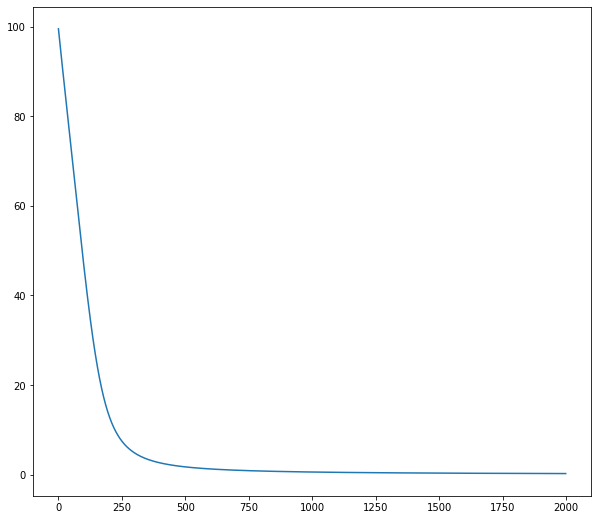

In [102]:
# Show the loss w.r.t step
plt.figure(figsize=(10, 9))
plt.plot(steps, losses)

In [105]:
def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)

# sample_idx = np.random.randint(0, len(samples))
# embeds = make_context_vector(samples[sample_idx][0], word_to_ix)  # example
# print(f'{samples[sample_idx][1]} => {embeds}')

In [106]:
for id in range(len(samples)):
  embeds = make_context_vector(samples[id][0], word_to_ix)  # example
  print(f'{samples[id][1]} => {embeds}')

computational => tensor([ 3, 12, 16, 13])
process => tensor([12, 13, 13, 14])
computational => tensor([13, 16, 14, 22])
processes => tensor([16, 13, 22,  8])
abstract => tensor([13, 14,  8,  7])
beings => tensor([14, 22,  7, 24])
inhabit => tensor([22,  8, 24,  4])
computers => tensor([ 8,  7,  4, 14])
evolve => tensor([ 7, 24, 14, 26])
processes => tensor([24,  4, 26, 22])
manipulate => tensor([ 4, 14, 22, 25])
abstract => tensor([14, 26, 25, 27])
things => tensor([26, 22, 27,  5])
called => tensor([22, 25,  5,  1])
data => tensor([25, 27,  1, 16])
evolution => tensor([27,  5, 16, 15])
process => tensor([ 5,  1, 15, 20])
directed => tensor([ 1, 16, 20,  2])
pattern => tensor([16, 15,  2, 27])
rules => tensor([15, 20, 27, 23])
called => tensor([20,  2, 23, 19])
program => tensor([ 2, 27, 19, 11])
people => tensor([27, 23, 11, 21])
create => tensor([23, 19, 21, 18])
programs => tensor([19, 11, 18, 14])
direct => tensor([11, 21, 14, 10])
processes => tensor([21, 18, 10,  6])
effect => te